<a href="https://colab.research.google.com/github/schaeffer-thom/ML-projects/blob/main/IK_6dof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("luisatencio/abb-irb-2400-arm-robot-kinematics-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/abb-irb-2400-arm-robot-kinematics-dataset


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [14]:
data = pd.read_csv('/kaggle/input/abb-irb-2400-arm-robot-kinematics-dataset/datasetIRB2400.csv')
data = data.rename(columns={f"q{i}_out": f"q{i}" for i in range(1, 7)})

y = data[['q1','q2','q3','q4','q5','q6']]

x = data[['x','y','z','roll','pitch','yaw','q1_in','q2_in','q3_in','q4_in','q5_in','q6_in']]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

#print(data.info())
#data.head()

In [15]:
# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(x_train)
X_test = scaler_X.transform(x_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


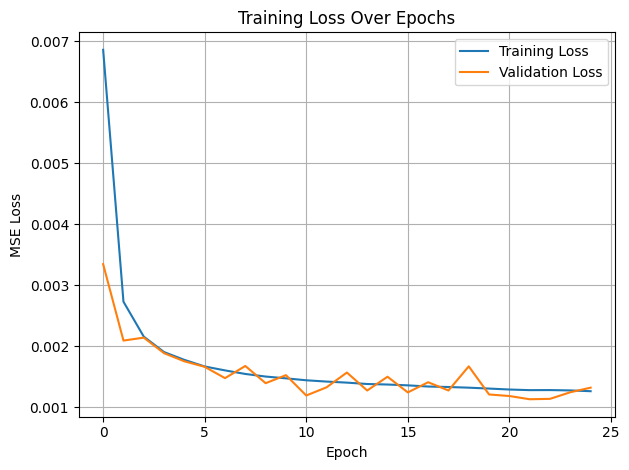

In [ ]:

# Build the model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(12,)),  # XYZ+RPY
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6)  # 6 joint angles output
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2, verbose=0)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

model.save('ik_model.keras')  # saves weights + architecture + optimizer state

In [6]:
import numpy as np
import matplotlib.pyplot as plt



# Compute individual DH transformation matrix
def dh_transform(a, alpha, d, theta):

    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

# Forward kinematics function
def forward_kinematics(joint_angles):
    """
    joint_angles: list or array of 6 joint angles in radians
    returns: 4x4 transformation matrix of the end-effector
    """
    assert len(joint_angles) == 6

    # DH Parameters: (a, alpha, d, theta)
    dh_params = [
        (0,    0,    0,   joint_angles[0]),
        (97,  -90,  440,  joint_angles[1]),
        (705,   0,    0,  joint_angles[2]),
        (135, -90,  264,  joint_angles[3]),
        (0,    90,  497,  joint_angles[4]),
        (0,   -90,   65,  joint_angles[5])
    ]

    T = np.eye(4)
    for a, alpha, d, theta in dh_params:
        T = np.dot(T, dh_transform(a, alpha, d, theta))

    return T

# Example usage
angles = [0, 0, 0, 0, 0, 0]  # All joints at 0°
T_end = forward_kinematics(angles)
print("End-effector pose:\n", T_end)

End-effector pose:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  9.37000000e+02]
 [ 0.00000000e+00 -5.98460069e-01 -8.01152636e-01 -1.04047958e+02]
 [ 0.00000000e+00  8.01152636e-01 -5.98460069e-01 -4.85087403e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [28]:
#----DEFINE PLOTTER-----

def plot_trajectory(joint_trajectory):
    """
    joint_trajectory: Nx6 array of joint angles (degrees)
    """
    positions = []
    for angles in joint_trajectory:
        T = forward_kinematics(angles)
        pos = T[:3, 3]  # Extract x, y, z
        positions.append(pos)

    positions = np.array(positions)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions[:,0], positions[:,1], positions[:,2], '-o', label='EE Path')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('End-Effector Trajectory')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [27]:
model = tf.keras.models.load_model('/ik_model.keras')

In [86]:
import numpy as np

def generate_linear_path(start, end, steps=50):
    """
    Generate a linear Cartesian path from start to end.

    Args:
        start: 3-element tuple (x0, y0, z0)
        end: 3-element tuple (x1, y1, z1)
        steps: Number of points along the path

    Returns:
        Nx3 array of positions
    """
    return np.linspace(start, end, steps)

# Example: Move along X from 0.4 to 0.6 meters, keeping Y and Z constant
start_pos = np.array([300, 300, 500])
end_pos = start_pos + np.array([200, 200, 200])
linear_path = generate_linear_path(start_pos, end_pos, steps=50)

# Step 1: Define neutral joint config from DH mid-ranges
neutral_joint_angles_rad = ([0.0, -5.0, -2.5, 0.0, 0.0, 0.0])
neutral_joint_angles_rad = np.deg2rad(neutral_joint_angles_rad)

# Step 2: Tile across full trajectory
initial_joint_inputs = np.tile(neutral_joint_angles_rad, (50, 1))
linear_input = np.hstack((linear_path, np.zeros((50, 3)), initial_joint_inputs))

linear_input_scaled = scaler_X.transform(linear_input)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [52]:


#----- CIRCULAR PATH -----

radius = 200  # mm
center = np.array([700, 730, 590])  # X, Y, Z center of circle
#center = np.array([0, 0, 0])  # X, Y, Z center of circle
num_points = 100
theta_vals = np.linspace(0, 2 * np.pi, num_points)

# Circle in XY plane at fixed Z
x_circle = center[0] + radius * np.cos(theta_vals)
y_circle = center[1] + radius * np.sin(theta_vals)
z_circle = np.full_like(x_circle, center[2])  # constant height

#  assemble inputs
circular_path = np.column_stack((x_circle, y_circle, z_circle))

# Step 1: Define neutral joint config from DH mid-ranges
neutral_joint_angles_rad = ([0.0, -5.0, -2.5, 0.0, 0.0, 0.0])

# Step 2: Tile across full circular trajectory
initial_joint_inputs = np.tile(neutral_joint_angles_rad, (num_points, 1))

# Step 3: Combine full input for the model: [XYZ, RPY, q1–q6]
circular_input = np.hstack((circular_path, np.zeros((num_points, 3)), initial_joint_inputs))

# --- Step 2: Normalize input using your trained scaler ---
circular_input_scaled = scaler_X.transform(circular_input)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [55]:
# --- Predict joint angles from IK model ---
pred_scaled = model.predict(circular_input_scaled)
#pred_scaled = model.predict(linear_input_scaled)
pred_joint_angles = scaler_y.inverse_transform(pred_scaled)




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [87]:
# ---- ITERATE WITH Q_IN ------
joint_trajectory = [] # Reset joint_trajectory
q_in =  np.deg2rad([0.0, -5.0, -2.5, 0.0, 0.0, 0.0])  # Start with neutral pose or a known initial guess

# Assuming 'path' is defined elsewhere and contains the desired end-effector positions
# If using circular_path, uncomment the line below and comment out the line above
path = linear_path

for pos in path:

    # Combine current position (XYZ), zero RPY, and previous joint angles (q_in)
    input = np.hstack((pos.reshape(1, -1), np.zeros((1, 3)), q_in.reshape(1, -1)))

    # Scale the input
    input_scaled = scaler_X.transform(input)

    # Predict joint angles using the model
    q_pred_scaled = model.predict(input_scaled)

    # Inverse transform to get actual joint angles
    q_pred = scaler_y.inverse_transform(q_pred_scaled)

    # Append the predicted joint angles (the single row) to the trajectory
    joint_trajectory.append(q_pred[0]) # Extract the first (and only) row

    # Update q_in for the next iteration
    q_in = q_pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [88]:
# --- Forward kinematics to get predicted EE positions ---
def get_end_effector_positions(joint_trajectory):
    positions = []
    for joint_angles in joint_trajectory:
        T = forward_kinematics(joint_angles)
        pos = T[:3, 3]  # Extract x, y, z
        positions.append(pos)
    return np.array(positions)


#predicted_positions = get_end_effector_positions(pred_joint_angles)
predicted_positions = get_end_effector_positions(joint_trajectory)

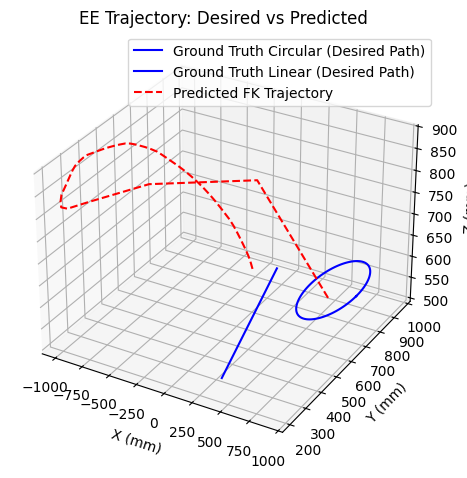

In [91]:
import matplotlib.pyplot as plt

# -----PLOTTING-----

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ground truth circular path
ax.plot(circular_path[:, 0], circular_path[:, 1], circular_path[:, 2],
        'b-', label='Ground Truth Circular (Desired Path)')

# Ground truth linear path
ax.plot(linear_path[:, 0], linear_path[:, 1], linear_path[:, 2],
        'b-', label='Ground Truth Linear (Desired Path)')

# Predicted FK path
ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2],
        'r--', label='Predicted FK Trajectory')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('EE Trajectory: Desired vs Predicted')
ax.legend()
plt.tight_layout()
plt.show()

**Results**

The predicted joint angles are producing forward kinematic motion which reflects the path desired. As it stands, I cannot be sure why the resulting FK path is in a different region, with different orientation, than the desired path. This is something I will explore further - Perhaps it is an issue of operating region. Additionally, I wonder if part of the issue is that we are passing a default q_in to the model for each prediction. Perhaps, instead we should be passing the last obtained q_out as the q_in for each successive prediction.

Update: using last predicted q did not improve results.